# Diffusion Maps + LAWGD Generative Modelling on MNIST

This notebook implements an autoencoder + diffusion-maps latent analysis, then mirrors the LAWGD scheme from Tests 1 & 2 to sample new MNIST digits directly in latent space.

**Pipeline:**

1. Load MNIST and normalize images.
2. Train an autoencoder (either MLP-based or CNN-based) to learn a low-dimensional latent space.
3. Map training images to latent codes.
4. Apply Diffusion Maps on latent codes to obtain diffusion coordinates for diagnostics.
5. Build the LAWGD kernel operators on the latent samples (same normalization as Tests 1 & 2).
6. Run LAWGD particle transport to draw new latent vectors.
7. Decode LAWGD latent vectors back to images and visually inspect generated digits.


In [1]:
# Configure core libraries, plotting defaults, and compute device
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    GPU_AVAILABLE = True
except Exception:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    GPU_AVAILABLE = False

np.random.seed(1)
torch.manual_seed(1)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu_lawgd = bool(GPU_AVAILABLE and torch.cuda.is_available())

print("=" * 50)
print("GPU Info")
print("=" * 50)
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}, Memory: {props.total_memory / 1024**3:.2f} GB")
else:
    print("No CUDA GPU available")

print(f"\nUsing device: {device}")
print(f"LAWGD GPU backend: {'enabled' if use_gpu_lawgd else 'disabled'}")

/workspace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU Info
CUDA version: 12.8
cuDNN version: 91002
Number of GPUs: 1
GPU 0: NVIDIA RTX A6000, Memory: 47.53 GB

Using device: cuda
LAWGD GPU backend: enabled


In [2]:
# Load MNIST datasets and build training/test data loaders
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1]
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))


Train size: 60000 Test size: 10000


In [3]:
# Define the fully connected autoencoder blocks used for the MLP baseline
latent_dim = 8  # dimension of the latent space

class MLPEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, x):
        return self.net(x)


class MLPDecoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, z):
        x_flat = self.net(z)
        return x_flat.view(-1, 1, 28, 28)


class MLPAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = MLPEncoder(latent_dim)
        self.decoder = MLPDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [4]:
# Define the convolutional autoencoder architecture for improved spatial modeling
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # 1x28x28 -> 32x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32x28x28 -> 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 64x14x14 -> 128x7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        z = self.fc(h)
        return z


class CNNDecoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128 * 7 * 7),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x7x7 -> 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # 64x14x14 -> 32x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),  # 32x28x28 -> 1x28x28
            nn.Sigmoid(),
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(-1, 128, 7, 7)
        x = self.deconv(h)
        return x


class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim=8):
        super().__init__()
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [5]:
# Choose which autoencoder variant to train and move it to the target device
# Option 1: MLP autoencoder
# autoencoder = MLPAutoencoder(latent_dim=latent_dim).to(device)

# Option 2: CNN autoencoder (default here)
autoencoder = CNNAutoencoder(latent_dim=latent_dim).to(device)

print(autoencoder)


CNNAutoencoder(
  (encoder): CNNEncoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (fc): Sequential(
      (0): Linear(in_features=6272, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=8, bias=True)
    )
  )
  (decoder): CNNDecoder(
    (fc): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=6272, bias=True)
 

In [6]:
# Train the selected autoencoder on MNIST with Adam, validation, and per-class loss analysis
num_epochs = 100
learning_rate = 1e-3

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

best_val_loss = float("inf")
best_epoch = 0

for epoch in range(num_epochs):
    # Training phase
    autoencoder.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        recon, z = autoencoder(images)
        loss = criterion(recon, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            recon, _ = autoencoder(images)
            val_loss += criterion(recon, images).item()

    avg_val_loss = val_loss / len(test_loader)

    # Track best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1

    print(f"Epoch [{epoch+1:2d}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print(f"\nBest validation loss: {best_val_loss:.4f} at epoch {best_epoch}")

Epoch [ 1/100] | Train Loss: 0.0284 | Val Loss: 0.0175
Epoch [ 2/100] | Train Loss: 0.0164 | Val Loss: 0.0153
Epoch [ 3/100] | Train Loss: 0.0147 | Val Loss: 0.0141
Epoch [ 4/100] | Train Loss: 0.0138 | Val Loss: 0.0137
Epoch [ 5/100] | Train Loss: 0.0132 | Val Loss: 0.0132
Epoch [ 6/100] | Train Loss: 0.0128 | Val Loss: 0.0129
Epoch [ 7/100] | Train Loss: 0.0124 | Val Loss: 0.0129
Epoch [ 8/100] | Train Loss: 0.0122 | Val Loss: 0.0128
Epoch [ 9/100] | Train Loss: 0.0119 | Val Loss: 0.0125
Epoch [10/100] | Train Loss: 0.0117 | Val Loss: 0.0123
Epoch [11/100] | Train Loss: 0.0115 | Val Loss: 0.0124
Epoch [12/100] | Train Loss: 0.0113 | Val Loss: 0.0121
Epoch [13/100] | Train Loss: 0.0112 | Val Loss: 0.0120
Epoch [14/100] | Train Loss: 0.0111 | Val Loss: 0.0121
Epoch [15/100] | Train Loss: 0.0109 | Val Loss: 0.0120
Epoch [16/100] | Train Loss: 0.0108 | Val Loss: 0.0119
Epoch [17/100] | Train Loss: 0.0107 | Val Loss: 0.0119
Epoch [18/100] | Train Loss: 0.0106 | Val Loss: 0.0120
Epoch [19/

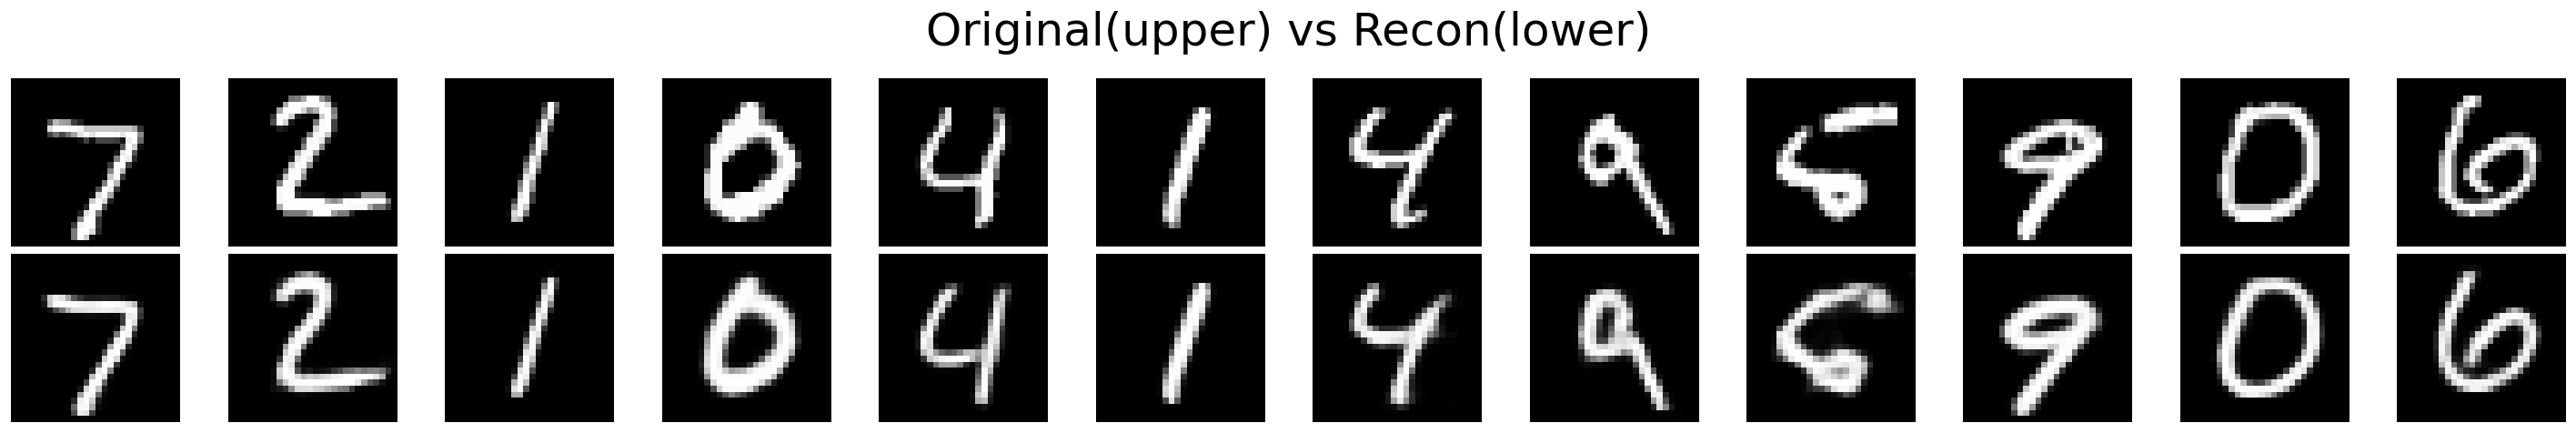

In [7]:
# Visualize a batch of original vs reconstructed digits to sanity-check training
autoencoder.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    recon, _ = autoencoder(images)

images_cpu = images.cpu().numpy()
recon_cpu = recon.cpu().numpy()

n_show = 12
fig, axes = plt.subplots(2, n_show, figsize=(2 * n_show, 4))
fig.suptitle("Original(upper) vs Recon(lower)", fontsize=30)
for i in range(n_show):
    axes[0, i].imshow(images_cpu[i, 0], cmap="gray")
    axes[0, i].axis("off")
    # axes[0, i].set_title("Original (DM)", fontsize=20)
    axes[1, i].imshow(recon_cpu[i, 0], cmap="gray")
    axes[1, i].axis("off")
    # axes[1, i].set_title("Recon (DM)", fontsize=20)
plt.tight_layout()
plt.show()


In [8]:
# Encode the full training set to collect latent vectors and labels for DM
autoencoder.eval()

all_latents = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        _, z = autoencoder(images)
        all_latents.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

Z = np.concatenate(all_latents, axis=0)   # shape (N, latent_dim)
y_labels = np.concatenate(all_labels, axis=0)

print("Latent codes shape:", Z.shape)


Latent codes shape: (60000, 8)


In [9]:
# Prepare the latent sample subset and kernel matrix required for diffusion maps
# Subsample for Diffusion Maps (e.g., 5000 points) with stratified sampling to keep label balance
max_dm_samples = 5000
N_total = Z.shape[0]

if N_total > max_dm_samples:
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=max_dm_samples, random_state=42)
    idx_dm, _ = next(splitter.split(Z, y_labels))
else:
    idx_dm = np.arange(N_total)

Z_dm_raw = Z[idx_dm]
labels_dm = y_labels[idx_dm]

# ========== STANDARDIZE latent codes for DM ==========
# This ensures all dimensions have similar scale for proper kernel computation
Z_dm_mean = np.mean(Z_dm_raw, axis=0, keepdims=True)
Z_dm_std = np.std(Z_dm_raw, axis=0, keepdims=True) + 1e-8
Z_dm = (Z_dm_raw - Z_dm_mean) / Z_dm_std  # Standardized latent codes
print(f"Standardized Z_dm: mean~{Z_dm.mean():.4f}, std~{Z_dm.std():.4f}")
# =====================================================

unique_labels, label_counts = np.unique(labels_dm, return_counts=True)
label_hist = {int(lbl): int(cnt) for lbl, cnt in zip(unique_labels, label_counts)}
print("Latent points used for DM:", Z_dm.shape)
print("Label histogram in DM subset:", label_hist)

# Pairwise distances (now on standardized data)
dists = pairwise_distances(Z_dm, metric="euclidean")

# Epsilon via median heuristic (can adjust multiplier for better separation)
med_sq = np.median(dists**2)
eps = med_sq / (2.0 * np.log(Z_dm.shape[0]))
# Alternative: use a smaller epsilon for tighter clustering
# eps = np.percentile(dists**2, 10)  # 10th percentile for local structure
print("Chosen epsilon:", eps)
print(f"Distance stats: min={dists[dists>0].min():.4f}, median={np.median(dists):.4f}, max={dists.max():.4f}")

# Gaussian kernel
K = np.exp(-dists**2 / (2.0 * eps))

# Row-normalize -> Markov matrix P
row_sums = K.sum(axis=1, keepdims=True)
P = K / row_sums

Standardized Z_dm: mean~0.0000, std~1.0000
Latent points used for DM: (5000, 8)
Label histogram in DM subset: {0: 493, 1: 562, 2: 496, 3: 511, 4: 487, 5: 452, 6: 493, 7: 522, 8: 488, 9: 496}
Chosen epsilon: 0.8143820505474144
Distance stats: min=0.1300, median=3.7246, max=13.1254


In [10]:
# Compute the leading diffusion-map eigenpairs to obtain coordinates and spectra
m = 15  # number of eigenvectors
t_diffusion = 1  # diffusion time for scaling coordinates

vals, vecs = eigs(P.T, k=m, which="LR")

idx_sort = np.argsort(-np.abs(vals))
vals = vals[idx_sort]
vecs = vecs[:, idx_sort]

lam = np.real(vals)
phi_raw = np.real(vecs)

# Scale diffusion coordinates by eigenvalues^t (standard Diffusion Maps embedding)
# This amplifies the coordinates to show structure at different scales
phi = phi_raw * (lam[np.newaxis, :] ** t_diffusion)

print("Leading eigenvalues:", lam)
print(f"Diffusion coords range: [{phi[:, 1:].min():.4f}, {phi[:, 1:].max():.4f}]")


Leading eigenvalues: [1.         0.99992597 0.99991446 0.99989621 0.99971443 0.99947032
 0.99943313 0.99805888 0.99803205 0.99727663 0.99426049 0.9921357
 0.99127232 0.986936   0.97856319]
Diffusion coords range: [-0.9997, 0.9997]


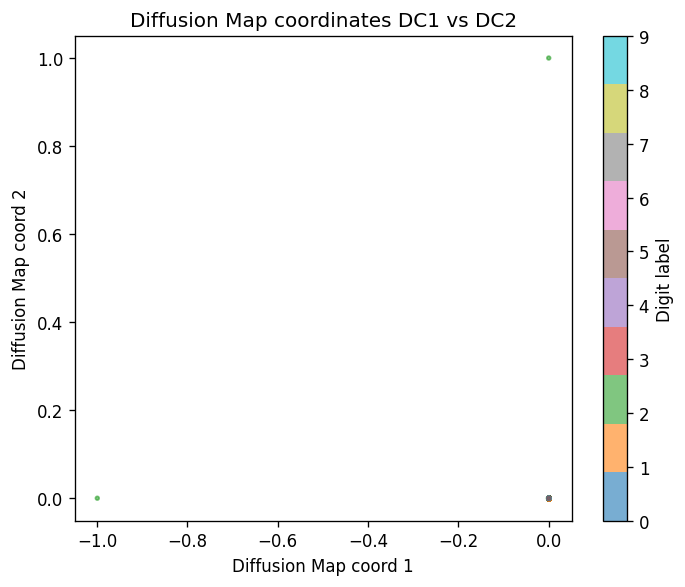

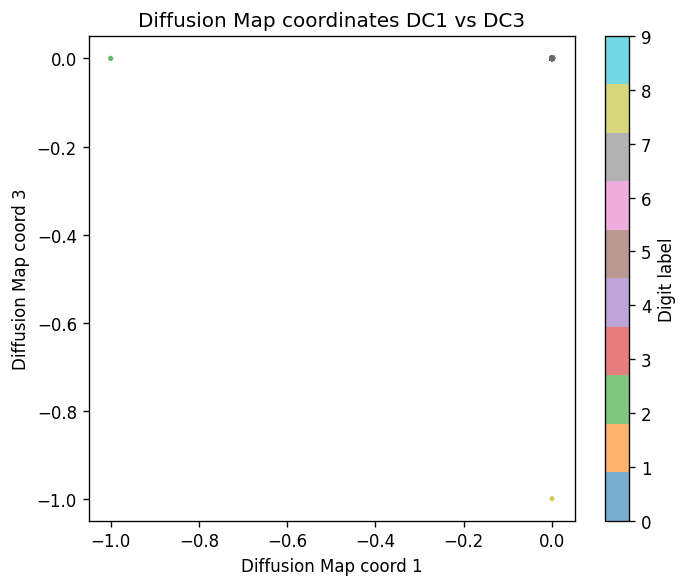

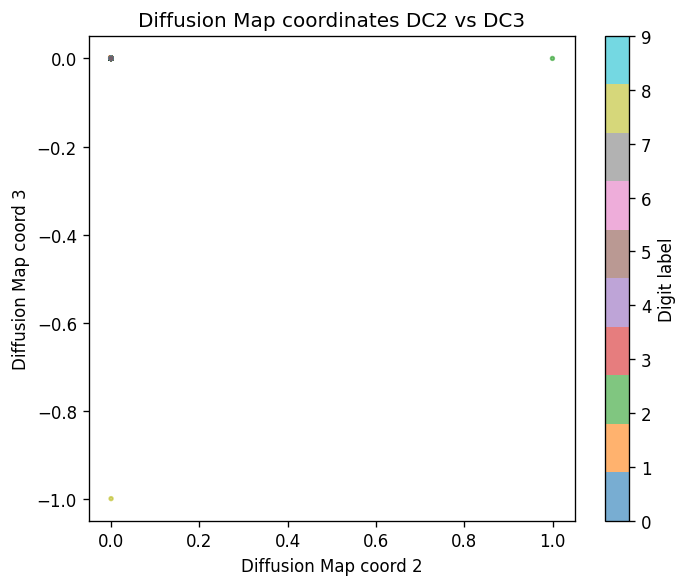

In [11]:
# Plot several diffusion-coordinate pairs to inspect class separation visually
pairs = [(1, 2), (1, 3), (2, 3)]
for i, j in pairs:
    dc_i = phi[:, i]
    dc_j = phi[:, j]

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(dc_i, dc_j, c=labels_dm, s=5, alpha=0.6, cmap="tab10")
    plt.xlabel(f"Diffusion Map coord {i}")
    plt.ylabel(f"Diffusion Map coord {j}")
    plt.title(f"Diffusion Map coordinates DC{i} vs DC{j}")
    plt.colorbar(scatter, label="Digit label")
    plt.tight_layout()
    plt.show()


Raw coordinate ranges (before filtering):
  DC1: [-0.9996, 0.0009]
  DC2: [-0.0009, 0.9996]
  DC3: [-0.9996, 0.0009]

IQR pre-filter: removed 56 extreme points (1.1%)
GMM filter: removed additional 495 points
Total outliers removed: 551 (11.0%)
Inliers kept: 4449

Filtered & scaled coordinate ranges (SPREAD_FACTOR=1.0):
  DC1: [-1.807, 2.209]
  DC2: [-2.207, 1.061]
  DC3: [-1.108, 2.209]


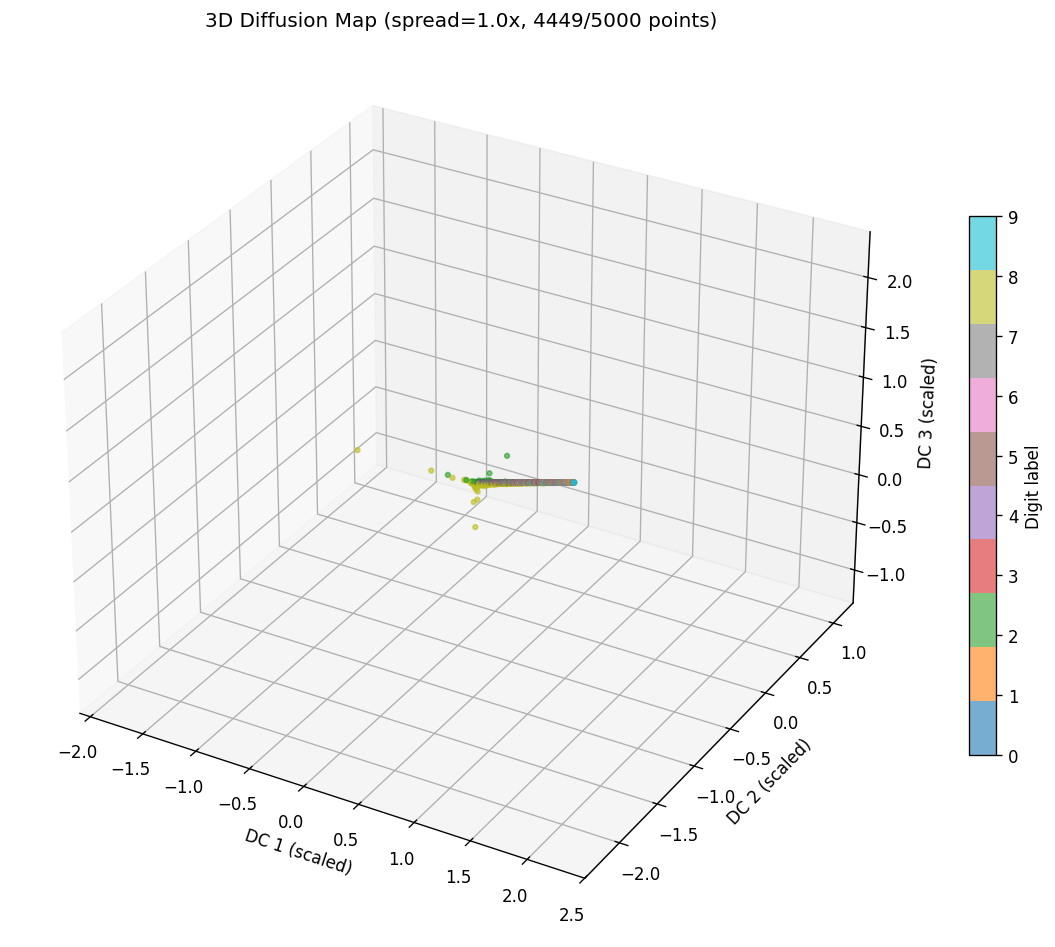

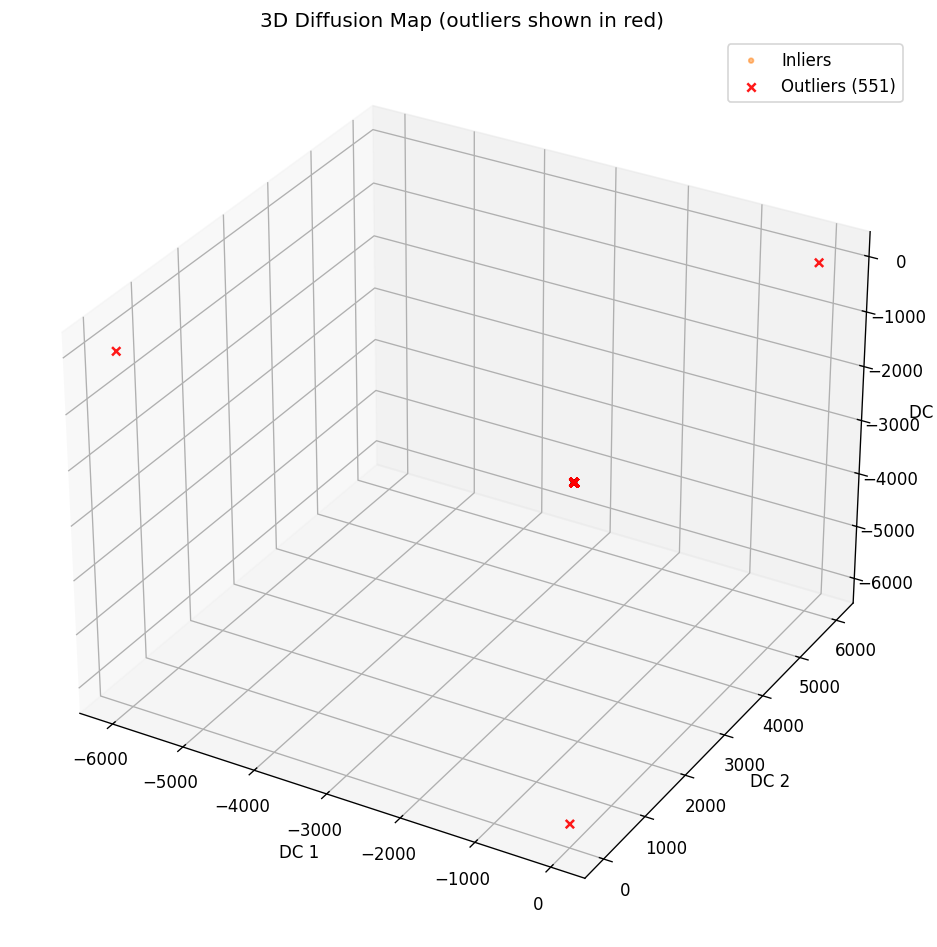

In [12]:
# 3D diffusion-coordinate visualization with GMM outlier filtering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from mpl_toolkits.mplot3d import Axes3D

# ============== RESCALE PARAMETER ==============
# Increase this value to spread clusters further apart
# Typical values: 1.0 (no change), 2.0-5.0 (moderate spread), 5.0-10.0 (large spread)
SPREAD_FACTOR = 1.0  # <-- Adjust this to control cluster separation
# ===============================================

# Use first 3 nontrivial diffusion coordinates for 3D plot
# Scale by eigenvalues to get proper diffusion distances (standard practice)
dc_1_raw = phi[:, 1] * lam[1]
dc_2_raw = phi[:, 2] * lam[2]
dc_3_raw = phi[:, 3] * lam[3]
coords_3d_raw = np.column_stack([dc_1_raw, dc_2_raw, dc_3_raw])

print(f"Raw coordinate ranges (before filtering):")
print(f"  DC1: [{dc_1_raw.min():.4f}, {dc_1_raw.max():.4f}]")
print(f"  DC2: [{dc_2_raw.min():.4f}, {dc_2_raw.max():.4f}]")
print(f"  DC3: [{dc_3_raw.min():.4f}, {dc_3_raw.max():.4f}]")

# Step 1: First pass - use IQR to remove extreme outliers before GMM
def iqr_filter(data, factor=3.0):
    """Remove points outside factor*IQR from Q1/Q3"""
    q1 = np.percentile(data, 25, axis=0)
    q3 = np.percentile(data, 75, axis=0)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = np.all((data >= lower) & (data <= upper), axis=1)
    return mask

iqr_mask = iqr_filter(coords_3d_raw, factor=2.5)
print(f"\nIQR pre-filter: removed {np.sum(~iqr_mask)} extreme points ({100*np.sum(~iqr_mask)/len(iqr_mask):.1f}%)")

# Step 2: Fit GMM on IQR-filtered data for finer outlier detection
coords_filtered = coords_3d_raw[iqr_mask]
n_gmm_components = 10
gmm = GaussianMixture(n_components=n_gmm_components, covariance_type='full', random_state=42)
gmm.fit(coords_filtered)

# Score ALL points with the GMM trained on filtered data
log_probs_all = gmm.score_samples(coords_3d_raw)
# Use a more aggressive threshold: bottom 5% of GMM scores
threshold = np.percentile(log_probs_all[iqr_mask], 10)
gmm_mask = log_probs_all >= threshold

# Combine both filters
inlier_mask = iqr_mask & gmm_mask

print(f"GMM filter: removed additional {np.sum(iqr_mask & ~gmm_mask)} points")
print(f"Total outliers removed: {np.sum(~inlier_mask)} ({100*np.sum(~inlier_mask)/len(inlier_mask):.1f}%)")
print(f"Inliers kept: {np.sum(inlier_mask)}")

# Step 3: Standardize inliers, then apply SPREAD_FACTOR to increase separation
scaler = RobustScaler()  # More robust to remaining outliers
coords_inliers = coords_3d_raw[inlier_mask]
coords_scaled = scaler.fit_transform(coords_inliers)

# Apply spread factor: multiply by SPREAD_FACTOR to increase inter-cluster distances
coords_spread = coords_scaled * SPREAD_FACTOR

dc_1_plot, dc_2_plot, dc_3_plot = coords_spread[:, 0], coords_spread[:, 1], coords_spread[:, 2]

print(f"\nFiltered & scaled coordinate ranges (SPREAD_FACTOR={SPREAD_FACTOR}):")
print(f"  DC1: [{dc_1_plot.min():.3f}, {dc_1_plot.max():.3f}]")
print(f"  DC2: [{dc_2_plot.min():.3f}, {dc_2_plot.max():.3f}]")
print(f"  DC3: [{dc_3_plot.min():.3f}, {dc_3_plot.max():.3f}]")

# Plot 3D with inliers only (properly filtered and spread)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    dc_1_plot, dc_2_plot, dc_3_plot,
    c=labels_dm[inlier_mask], s=8, alpha=0.6, cmap="tab10"
)
ax.set_xlabel("DC 1 (scaled)")
ax.set_ylabel("DC 2 (scaled)")
ax.set_zlabel("DC 3 (scaled)")
ax.set_title(f"3D Diffusion Map (spread={SPREAD_FACTOR}x, {np.sum(inlier_mask)}/{len(inlier_mask)} points)")
fig.colorbar(scatter, ax=ax, label="Digit label", shrink=0.6)
plt.tight_layout()
plt.show()

# Also show where outliers were (using same scaling)
scaler_all = RobustScaler().fit(coords_3d_raw[inlier_mask])
coords_all_scaled = scaler_all.transform(coords_3d_raw) * SPREAD_FACTOR
dc_1_all, dc_2_all, dc_3_all = coords_all_scaled[:, 0], coords_all_scaled[:, 1], coords_all_scaled[:, 2]

fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(
    dc_1_all[inlier_mask], dc_2_all[inlier_mask], dc_3_all[inlier_mask],
    c=labels_dm[inlier_mask], s=8, alpha=0.5, cmap="tab10", label="Inliers"
)
ax2.scatter(
    dc_1_all[~inlier_mask], dc_2_all[~inlier_mask], dc_3_all[~inlier_mask],
    c='red', s=25, alpha=0.9, marker='x', label=f"Outliers ({np.sum(~inlier_mask)})"
)
ax2.set_xlabel("DC 1")
ax2.set_ylabel("DC 2")
ax2.set_zlabel("DC 3")
ax2.set_title("3D Diffusion Map (outliers shown in red)")
ax2.legend()
plt.tight_layout()
plt.show()

In [13]:
# Compute diffusion-space mean and covariance for Gaussian diagnostics
num_dc = 8  # number of nontrivial diffusion coords to use (<= m-1)
Y_dm = phi[:, 1:1 + num_dc]
print("Diffusion-space data shape:", Y_dm.shape)

mu_Y = np.mean(Y_dm, axis=0)
cov_Y = np.cov(Y_dm.T)

print("Mean in diffusion space:", mu_Y)
print("Covariance shape:", cov_Y.shape)

Diffusion-space data shape: (5000, 8)
Mean in diffusion space: [-1.16800192e-13  5.05194775e-15  4.71317874e-14 -3.36617845e-14
 -3.87556653e-16 -9.22555365e-15  2.31716868e-15  4.25862678e-15]
Covariance shape: (8, 8)


## LAWGD-based latent generation
Following the LAWGD workflow from Tests 1 & 2, we now treat the autoencoder latents as the target samples and run Wasserstein gradient dynamics directly in latent space. Diffusion maps remain available above for visualization, but the sampling path below no longer uses the Gaussian model.

In [14]:
# Standardize DM latents and build the LAWGD kernel operators
# NOTE: Z_dm is already standardized in Cell 11, so we use it directly
X_tar = Z_dm.astype(np.float64)  # target samples for LAWGD (already standardized)
sq_tar = np.sum(X_tar ** 2, axis=1)

lawgd_dists = pairwise_distances(X_tar, metric="euclidean")
eps_lawgd = np.median(lawgd_dists**2) / (2.0 * np.log(X_tar.shape[0] + 1))
eps_lawgd = float(max(eps_lawgd, 1e-6))
data_kernel = np.exp(-lawgd_dists**2 / (2.0 * eps_lawgd))

p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
# rw_kernel = data_kernel_norm / (D_y[:, None] + 1e-12)
rw_kernel = np.nan_to_num(rw_kernel)

print("LAWGD target shape:", X_tar.shape)
print("LAWGD epsilon:", eps_lawgd)

LAWGD target shape: (5000, 8)
LAWGD epsilon: 0.8143629413213223


In [15]:
# Build spectral quantities and LAWGD weights
lambda_ns, phi = np.linalg.eigh(rw_kernel)
phi = np.real(phi[:, ::-1])
lambda_ns = np.real(lambda_ns[::-1])

tol = 1e-6
reg = 1e-3
# lambda_ = -lambda_ns + 1.0
lambda_ = lambda_ns - 1.0
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1.0 / np.clip(lambda_[1:], 1e-12, None)
inv_lambda *= eps_lawgd

lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = eps_lawgd / (lambda_ns[mask] + reg)
above_tol = int(np.sum(mask))
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

print("Retained eigenvectors for LAWGD:", above_tol)

Retained eigenvectors for LAWGD: 4830


## EDMD dictionary-learning pipeline
We now replicate the Test 2 EDMD workflow on the MNIST latents: learn a sparse dictionary on the standardized targets, build a stochastic DMD operator in the resulting feature space, and feed the Koopman spectrum into LAWGD for a third generative path. The next cells construct the KDE drift pairs that seed the dictionary stage.

In [16]:
# KDE-based drift estimation and Langevin evolution to build EDMD pairs
dt_edmd = 0.1  # time step for EDMD Langevin evolution
dist2_edmd = pairwise_distances(X_tar, metric="sqeuclidean")  # returns squared distances directly
h_edmd = np.sqrt(np.median(dist2_edmd) + 1e-12)
W_edmd = np.exp(-dist2_edmd / (2.0 * (h_edmd ** 2)))
sumW_edmd = np.sum(W_edmd, axis=1, keepdims=True) + 1e-12
weighted_means_edmd = W_edmd @ X_tar / sumW_edmd
score_edmd = (weighted_means_edmd - X_tar) / (h_edmd ** 2)  # KDE score = drift term

# Langevin step with unit diffusion so the stochastic term uses sqrt(2 dt)
xi_edmd = np.random.normal(0.0, 1.0, size=X_tar.shape)
X_tar_next = X_tar + dt_edmd * score_edmd + np.sqrt(2.0 * dt_edmd) * xi_edmd

print("EDMD drift bandwidth h:", h_edmd)
print("X_tar_next stats -> mean {:.4f}, std {:.4f}".format(X_tar_next.mean(), X_tar_next.std()))

EDMD drift bandwidth h: 3.724580340244346
X_tar_next stats -> mean 0.0023, std 1.0918


### Dictionary learning and Koopman operator
With the EDMD drift pairs in place, we now learn a sparse dictionary on the standardized targets, construct the stochastic DMD operator in that feature space, and feed its spectrum back into LAWGD.

In [17]:
# Learn a sparse dictionary on standardized LAWGD targets and encode Koopman pairs
n_dict_components = 200
dict_alpha = 1e-3
dict_batch = 256
dict_max_iter = 500
dict_random_state = 42

dict_model = MiniBatchDictionaryLearning(
    n_components=n_dict_components,
    alpha=dict_alpha,
    batch_size=dict_batch,
    max_iter=dict_max_iter,
    random_state=dict_random_state,
    verbose=0,
    fit_algorithm="lars"
)
dict_model.fit(X_tar)

Phi_X = dict_model.transform(X_tar)
Phi_Y = dict_model.transform(X_tar_next)
Phi_X = np.hstack([np.ones((Phi_X.shape[0], 1)), Phi_X])
Phi_Y = np.hstack([np.ones((Phi_Y.shape[0], 1)), Phi_Y])

print("Dictionary atoms:", dict_model.components_.shape)
print("Dictionary codes (current):", Phi_X.shape)
print("Dictionary codes (next):", Phi_Y.shape)

Dictionary atoms: (200, 8)
Dictionary codes (current): (5000, 201)
Dictionary codes (next): (5000, 201)


In [18]:
# Build the EDMD operator in dictionary space and extract Koopman spectrum
reg_edmd = 1e-3
N_edmd, m_edmd = Phi_X.shape
G_edmd = (Phi_X.T @ Phi_X) / N_edmd + reg_edmd * np.eye(m_edmd)
A_edmd = (Phi_X.T @ Phi_Y) / N_edmd

eigvals_edmd, eigvecs_edmd = eig(A_edmd, G_edmd)
idx_edmd = np.argsort(-eigvals_edmd.real)
eigvals_edmd = eigvals_edmd[idx_edmd]
eigvecs_edmd = eigvecs_edmd[:, idx_edmd]

efuns_edmd = Phi_X @ eigvecs_edmd

print("EDMD eigenvalues (first 6):", np.round(eigvals_edmd[:6].real, 4))
print("EDMD dictionary modes shape:", efuns_edmd.shape)

EDMD eigenvalues (first 6): [0.9985 0.9159 0.9159 0.8959 0.8851 0.8706]
EDMD dictionary modes shape: (5000, 201)


In [19]:
# Prepare EDMD-derived LAWGD weights (skip constant mode)
lambda_ns_edmd = eigvals_edmd.real
lambda_gen_edmd = (lambda_ns_edmd - 1.0) / dt_edmd
# lambda_gen_edmd = (1.0 - lambda_ns_edmd) / dt_edmd

mode_skip_edmd = 1
eig_threshold_edmd = 0.1  # keep more Koopman modes for generative transport
valid_idx_edmd = np.arange(mode_skip_edmd, lambda_ns_edmd.shape[0])
valid_mask_edmd = lambda_ns_edmd[mode_skip_edmd:] > eig_threshold_edmd
valid_idx_edmd = valid_idx_edmd[valid_mask_edmd]

if valid_idx_edmd.size == 0:
    raise RuntimeError("No EDMD modes survived the threshold; adjust eig_threshold_edmd or dictionary size.")

phi_trunc_edmd = np.real(efuns_edmd[:, valid_idx_edmd])
lambda_gen_inv_edmd = np.zeros_like(lambda_gen_edmd)
mask_nonzero_edmd = np.abs(lambda_gen_edmd) > 1e-6
lambda_gen_inv_edmd[mask_nonzero_edmd] = 1.0 / lambda_gen_edmd[mask_nonzero_edmd]
lambda_ns_s_ns_edmd = lambda_gen_inv_edmd[valid_idx_edmd].real

print(f"EDMD kept {valid_idx_edmd.size} modes (threshold {eig_threshold_edmd})")

EDMD kept 179 modes (threshold 0.1)


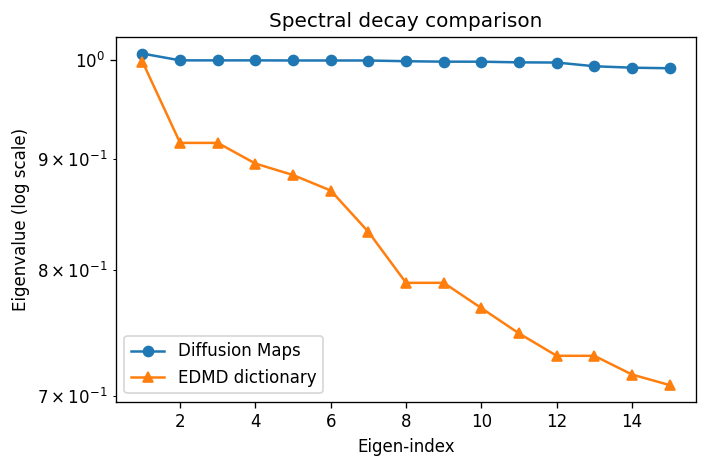

In [20]:
# Compare diffusion-map and EDMD spectra
n_show_eigs = 15
plt.figure(figsize=(6, 4))
plt.semilogy(range(1, n_show_eigs + 1), lambda_ns[:n_show_eigs], marker="o", label="Diffusion Maps")
plt.semilogy(
    range(1, min(n_show_eigs, lambda_ns_edmd.size) + 1),
    lambda_ns_edmd[:n_show_eigs],
    marker="^",
    label="EDMD dictionary",
)
plt.xlabel("Eigen-index")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Spectral decay comparison")
plt.legend()
plt.tight_layout()
plt.show()

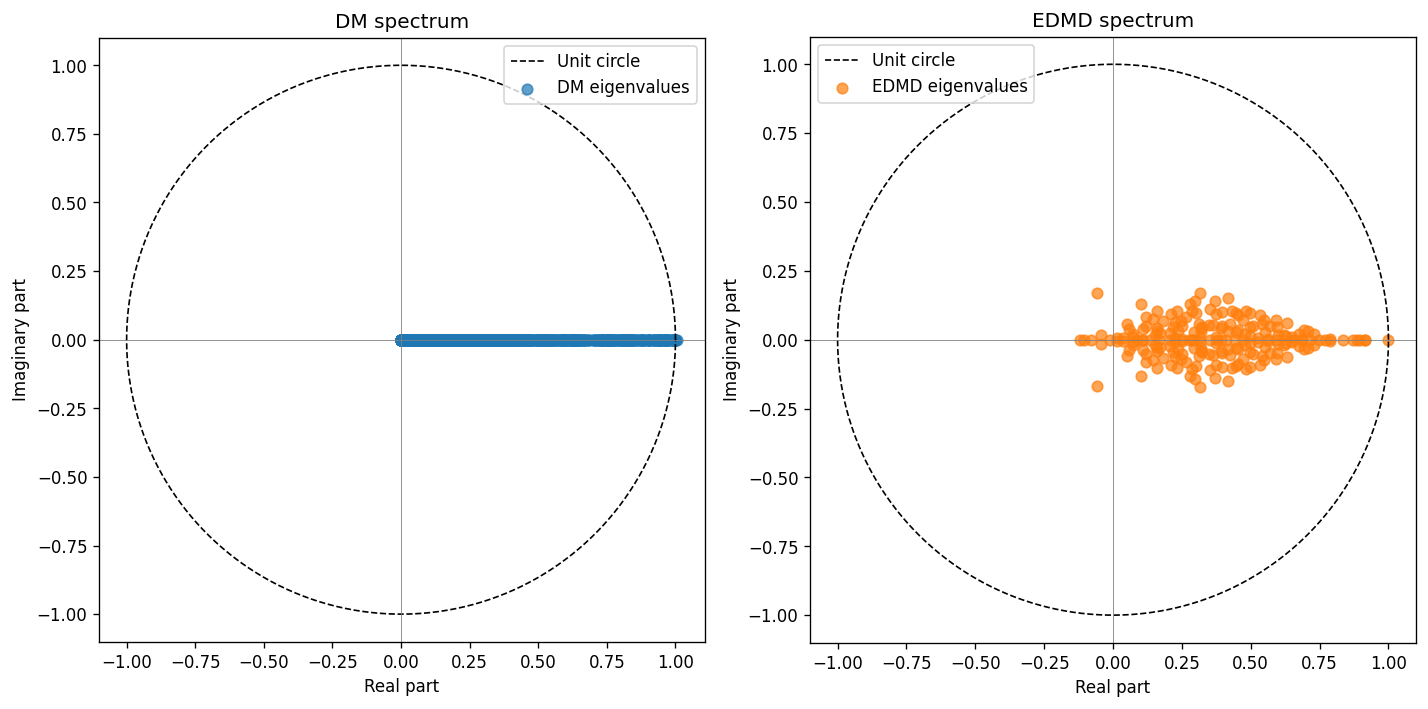

In [21]:
# Visualize DM and EDMD eigenvalues on separate unit circles (including leading mode)
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Common unit circle
theta = np.linspace(0, 2 * np.pi, 400)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Left: DM spectrum (real eigenvalues), show first above_tol modes (includes leading one)
ax_dm = axes[0]
ax_dm.plot(circle_x, circle_y, "k--", linewidth=1.0, label="Unit circle")
lambda_ns_dm_plot = lambda_ns[:above_tol]
ax_dm.scatter(lambda_ns_dm_plot, np.zeros_like(lambda_ns_dm_plot),
               c="tab:blue", s=40, alpha=0.7, label="DM eigenvalues")
ax_dm.axhline(0.0, color="gray", linewidth=0.5)
ax_dm.axvline(0.0, color="gray", linewidth=0.5)
ax_dm.set_xlabel("Real part")
ax_dm.set_ylabel("Imaginary part")
ax_dm.set_title("DM spectrum")
ax_dm.set_aspect("equal", adjustable="box")
ax_dm.legend()

# Right: EDMD spectrum (possibly complex), show leading n_show_eigs modes (including index 0)
ax_edmd = axes[1]
ax_edmd.plot(circle_x, circle_y, "k--", linewidth=1.0, label="Unit circle")
n_show_edmd_circle = min(above_tol, eigvals_edmd.size)
eigvals_edmd_plot = eigvals_edmd[:n_show_edmd_circle]
ax_edmd.scatter(eigvals_edmd_plot.real, eigvals_edmd_plot.imag,
                 c="tab:orange", s=40, alpha=0.7, label="EDMD eigenvalues")
ax_edmd.axhline(0.0, color="gray", linewidth=0.5)
ax_edmd.axvline(0.0, color="gray", linewidth=0.5)
ax_edmd.set_xlabel("Real part")
ax_edmd.set_ylabel("Imaginary part")
ax_edmd.set_title("EDMD spectrum")
ax_edmd.set_aspect("equal", adjustable="box")
ax_edmd.legend()

plt.tight_layout()
plt.show()

In [22]:
# Inspect leading eigenvalues for DM and EDMD around the truncation
n_print = 10
print("=== Diffusion Maps (DM) eigenvalues ===")
print("all lambda_ns[:n_print]:", np.round(lambda_ns[:n_print], 6))
print()
print("=== EDMD eigenvalues ===")
print("eigvals_edmd (real parts, first n_print):", np.round(eigvals_edmd[:n_print].real, 6))


=== Diffusion Maps (DM) eigenvalues ===
all lambda_ns[:n_print]: [1.007192 0.999959 0.999948 0.999942 0.999821 0.999804 0.9998   0.999032
 0.998568 0.998531]

=== EDMD eigenvalues ===
eigvals_edmd (real parts, first n_print): [0.998501 0.915896 0.915896 0.89595  0.885111 0.870616 0.8332   0.789209
 0.789209 0.768266]


## LAWGD transports with shared latents
Both diffusion-map (DM) and EDMD spectra feed Wasserstein dynamics below. Each transport reuses the same standardized targets `X_tar`, so differences stem solely from their generator spectra.

In [80]:
m_particles = 100
num_iters = 1000
step_size = 0.1
rng_seed = np.random.default_rng(1)

In [81]:
# Run LAWGD driven by the diffusion-map spectrum
m_particles_dm = m_particles
num_iters_dm = num_iters
step_size_dm = step_size
latent_dim = X_tar.shape[1]
rng_dm = rng_seed

grad_fn = grad_ker1_gpu if use_gpu_lawgd else grad_ker1
K_eval_fn = K_tar_eval_gpu if use_gpu_lawgd else K_tar_eval
xp = cp if use_gpu_lawgd else np

init_particles_dm = rng_dm.normal(0.0, 1.0, size=(m_particles_dm, latent_dim))
if use_gpu_lawgd:
    X_tar_dm_dev = cp.asarray(X_tar)
    p_tar_dm_dev = cp.asarray(p_tar)
    sq_tar_dm_dev = cp.asarray(sq_tar)
    D_vec_dm_dev = cp.asarray(D_vec)
    phi_trunc_dm_dev = cp.asarray(phi_trunc)
    lambda_ns_s_ns_dm_dev = cp.asarray(lambda_ns_s_ns)
    x_hist_dm = cp.zeros((m_particles_dm, latent_dim, num_iters_dm), dtype=cp.float64)
    x_hist_dm[:, :, 0] = cp.asarray(init_particles_dm, dtype=cp.float64)
else:
    X_tar_dm_dev = X_tar
    p_tar_dm_dev = p_tar
    sq_tar_dm_dev = sq_tar
    D_vec_dm_dev = D_vec
    phi_trunc_dm_dev = phi_trunc
    lambda_ns_s_ns_dm_dev = lambda_ns_s_ns
    x_hist_dm = np.zeros((m_particles_dm, latent_dim, num_iters_dm), dtype=np.float64)
    x_hist_dm[:, :, 0] = init_particles_dm

lawgd_loop_dm = trange(num_iters_dm - 1, desc="LAWGD (DM)", unit="step")
for t in lawgd_loop_dm:
    grad_matrix = grad_fn(x_hist_dm[:, :, t], X_tar_dm_dev, p_tar_dm_dev, sq_tar_dm_dev, D_vec_dm_dev, eps_lawgd)
    cross_matrix = K_eval_fn(X_tar_dm_dev, x_hist_dm[:, :, t], p_tar_dm_dev, sq_tar_dm_dev, D_vec_dm_dev, eps_lawgd)
    tmp = phi_trunc_dm_dev.T @ cross_matrix
    tmp = lambda_ns_s_ns_dm_dev[:, None] * tmp
    lawgd_push = phi_trunc_dm_dev @ tmp
    for dim in range(latent_dim):
        sum_term = grad_matrix[:, :, dim] @ lawgd_push
        x_hist_dm[:, dim, t + 1] = x_hist_dm[:, dim, t] - (step_size_dm / m_particles_dm) * xp.sum(sum_term, axis=1)
    if (t + 1) % 25 == 0 or (t + 1) == num_iters_dm - 1:
        step_norm = x_hist_dm[:, :, t + 1] - x_hist_dm[:, :, t]
        if use_gpu_lawgd:
            mean_disp = float(cp.mean(cp.linalg.norm(step_norm, axis=1)).get())
        else:
            mean_disp = float(np.mean(np.linalg.norm(step_norm, axis=1)))
        lawgd_loop_dm.set_postfix({"mean_step": f"{mean_disp:.3e}"})

if use_gpu_lawgd:
    Z_new_dm_std = cp.asnumpy(x_hist_dm[:, :, -1])
else:
    Z_new_dm_std = x_hist_dm[:, :, -1]

Z_new_lawgd_dm = Z_new_dm_std * Z_dm_std + Z_dm_mean
print("DM-LAWGD latent samples shape:", Z_new_lawgd_dm.shape)

LAWGD (DM):   1%|          | 11/999 [00:00<00:09, 107.86step/s]

LAWGD (DM): 100%|██████████| 999/999 [00:30<00:00, 32.58step/s, mean_step=0.000e+00]

DM-LAWGD latent samples shape: (100, 8)


In [82]:
# Run LAWGD using the EDMD dictionary spectrum
m_particles_edmd = m_particles
num_iters_edmd = num_iters
step_size_edmd = step_size
rng_edmd = rng_seed

grad_fn = grad_ker1_gpu if use_gpu_lawgd else grad_ker1
K_eval_fn = K_tar_eval_gpu if use_gpu_lawgd else K_tar_eval
xp = cp if use_gpu_lawgd else np

init_particles_edmd = rng_edmd.normal(0.0, 1.0, size=(m_particles_edmd, latent_dim))
if use_gpu_lawgd:
    X_tar_edmd_dev = cp.asarray(X_tar)
    p_tar_edmd_dev = cp.asarray(p_tar)
    sq_tar_edmd_dev = cp.asarray(sq_tar)
    D_vec_edmd_dev = cp.asarray(D_vec)
    phi_trunc_edmd_dev = cp.asarray(phi_trunc_edmd)
    lambda_ns_s_ns_edmd_dev = cp.asarray(lambda_ns_s_ns_edmd)
    x_hist_edmd = cp.zeros((m_particles_edmd, latent_dim, num_iters_edmd), dtype=cp.float64)
    x_hist_edmd[:, :, 0] = cp.asarray(init_particles_edmd, dtype=cp.float64)
else:
    X_tar_edmd_dev = X_tar
    p_tar_edmd_dev = p_tar
    sq_tar_edmd_dev = sq_tar
    D_vec_edmd_dev = D_vec
    phi_trunc_edmd_dev = phi_trunc_edmd
    lambda_ns_s_ns_edmd_dev = lambda_ns_s_ns_edmd
    x_hist_edmd = np.zeros((m_particles_edmd, latent_dim, num_iters_edmd), dtype=np.float64)
    x_hist_edmd[:, :, 0] = init_particles_edmd

lawgd_loop_edmd = trange(num_iters_edmd - 1, desc="LAWGD (EDMD)", unit="step")
for t in lawgd_loop_edmd:
    grad_matrix = grad_fn(x_hist_edmd[:, :, t], X_tar_edmd_dev, p_tar_edmd_dev, sq_tar_edmd_dev, D_vec_edmd_dev, eps_lawgd)
    cross_matrix = K_eval_fn(X_tar_edmd_dev, x_hist_edmd[:, :, t], p_tar_edmd_dev, sq_tar_edmd_dev, D_vec_edmd_dev, eps_lawgd)
    tmp = phi_trunc_edmd_dev.T @ cross_matrix
    tmp = lambda_ns_s_ns_edmd_dev[:, None] * tmp
    lawgd_push = phi_trunc_edmd_dev @ tmp
    for dim in range(latent_dim):
        sum_term = grad_matrix[:, :, dim] @ lawgd_push
        x_hist_edmd[:, dim, t + 1] = x_hist_edmd[:, dim, t] - (step_size_edmd / m_particles_edmd) * xp.sum(sum_term, axis=1)
    if (t + 1) % 25 == 0 or (t + 1) == num_iters_edmd - 1:
        step_norm = x_hist_edmd[:, :, t + 1] - x_hist_edmd[:, :, t]
        if use_gpu_lawgd:
            mean_disp = float(cp.mean(cp.linalg.norm(step_norm, axis=1)).get())
        else:
            mean_disp = float(np.mean(np.linalg.norm(step_norm, axis=1)))
        lawgd_loop_edmd.set_postfix({"mean_step": f"{mean_disp:.3e}"})

if use_gpu_lawgd:
    Z_new_edmd_std = cp.asnumpy(x_hist_edmd[:, :, -1])
else:
    Z_new_edmd_std = x_hist_edmd[:, :, -1]

Z_new_lawgd_edmd = Z_new_edmd_std * Z_dm_std + Z_dm_mean
print("EDMD-LAWGD latent samples shape:", Z_new_lawgd_edmd.shape)

LAWGD (EDMD): 100%|██████████| 999/999 [00:07<00:00, 139.27step/s, mean_step=9.321e-03]

EDMD-LAWGD latent samples shape: (100, 8)


## Decode and visualize transports
After both transports converge, decode the latent samples with the shared autoencoder decoder and display each batch for visual comparison.

In [83]:
# Decode DM-LAWGD latent vectors
autoencoder.eval()
Z_new_dm_tensor = torch.from_numpy(Z_new_lawgd_dm).float().to(device)

with torch.no_grad():
    dm_images = autoencoder.decoder(Z_new_dm_tensor)

dm_images_cpu = dm_images.cpu().numpy()
print("DM-LAWGD images shape:", dm_images_cpu.shape)

DM-LAWGD images shape: (100, 1, 28, 28)


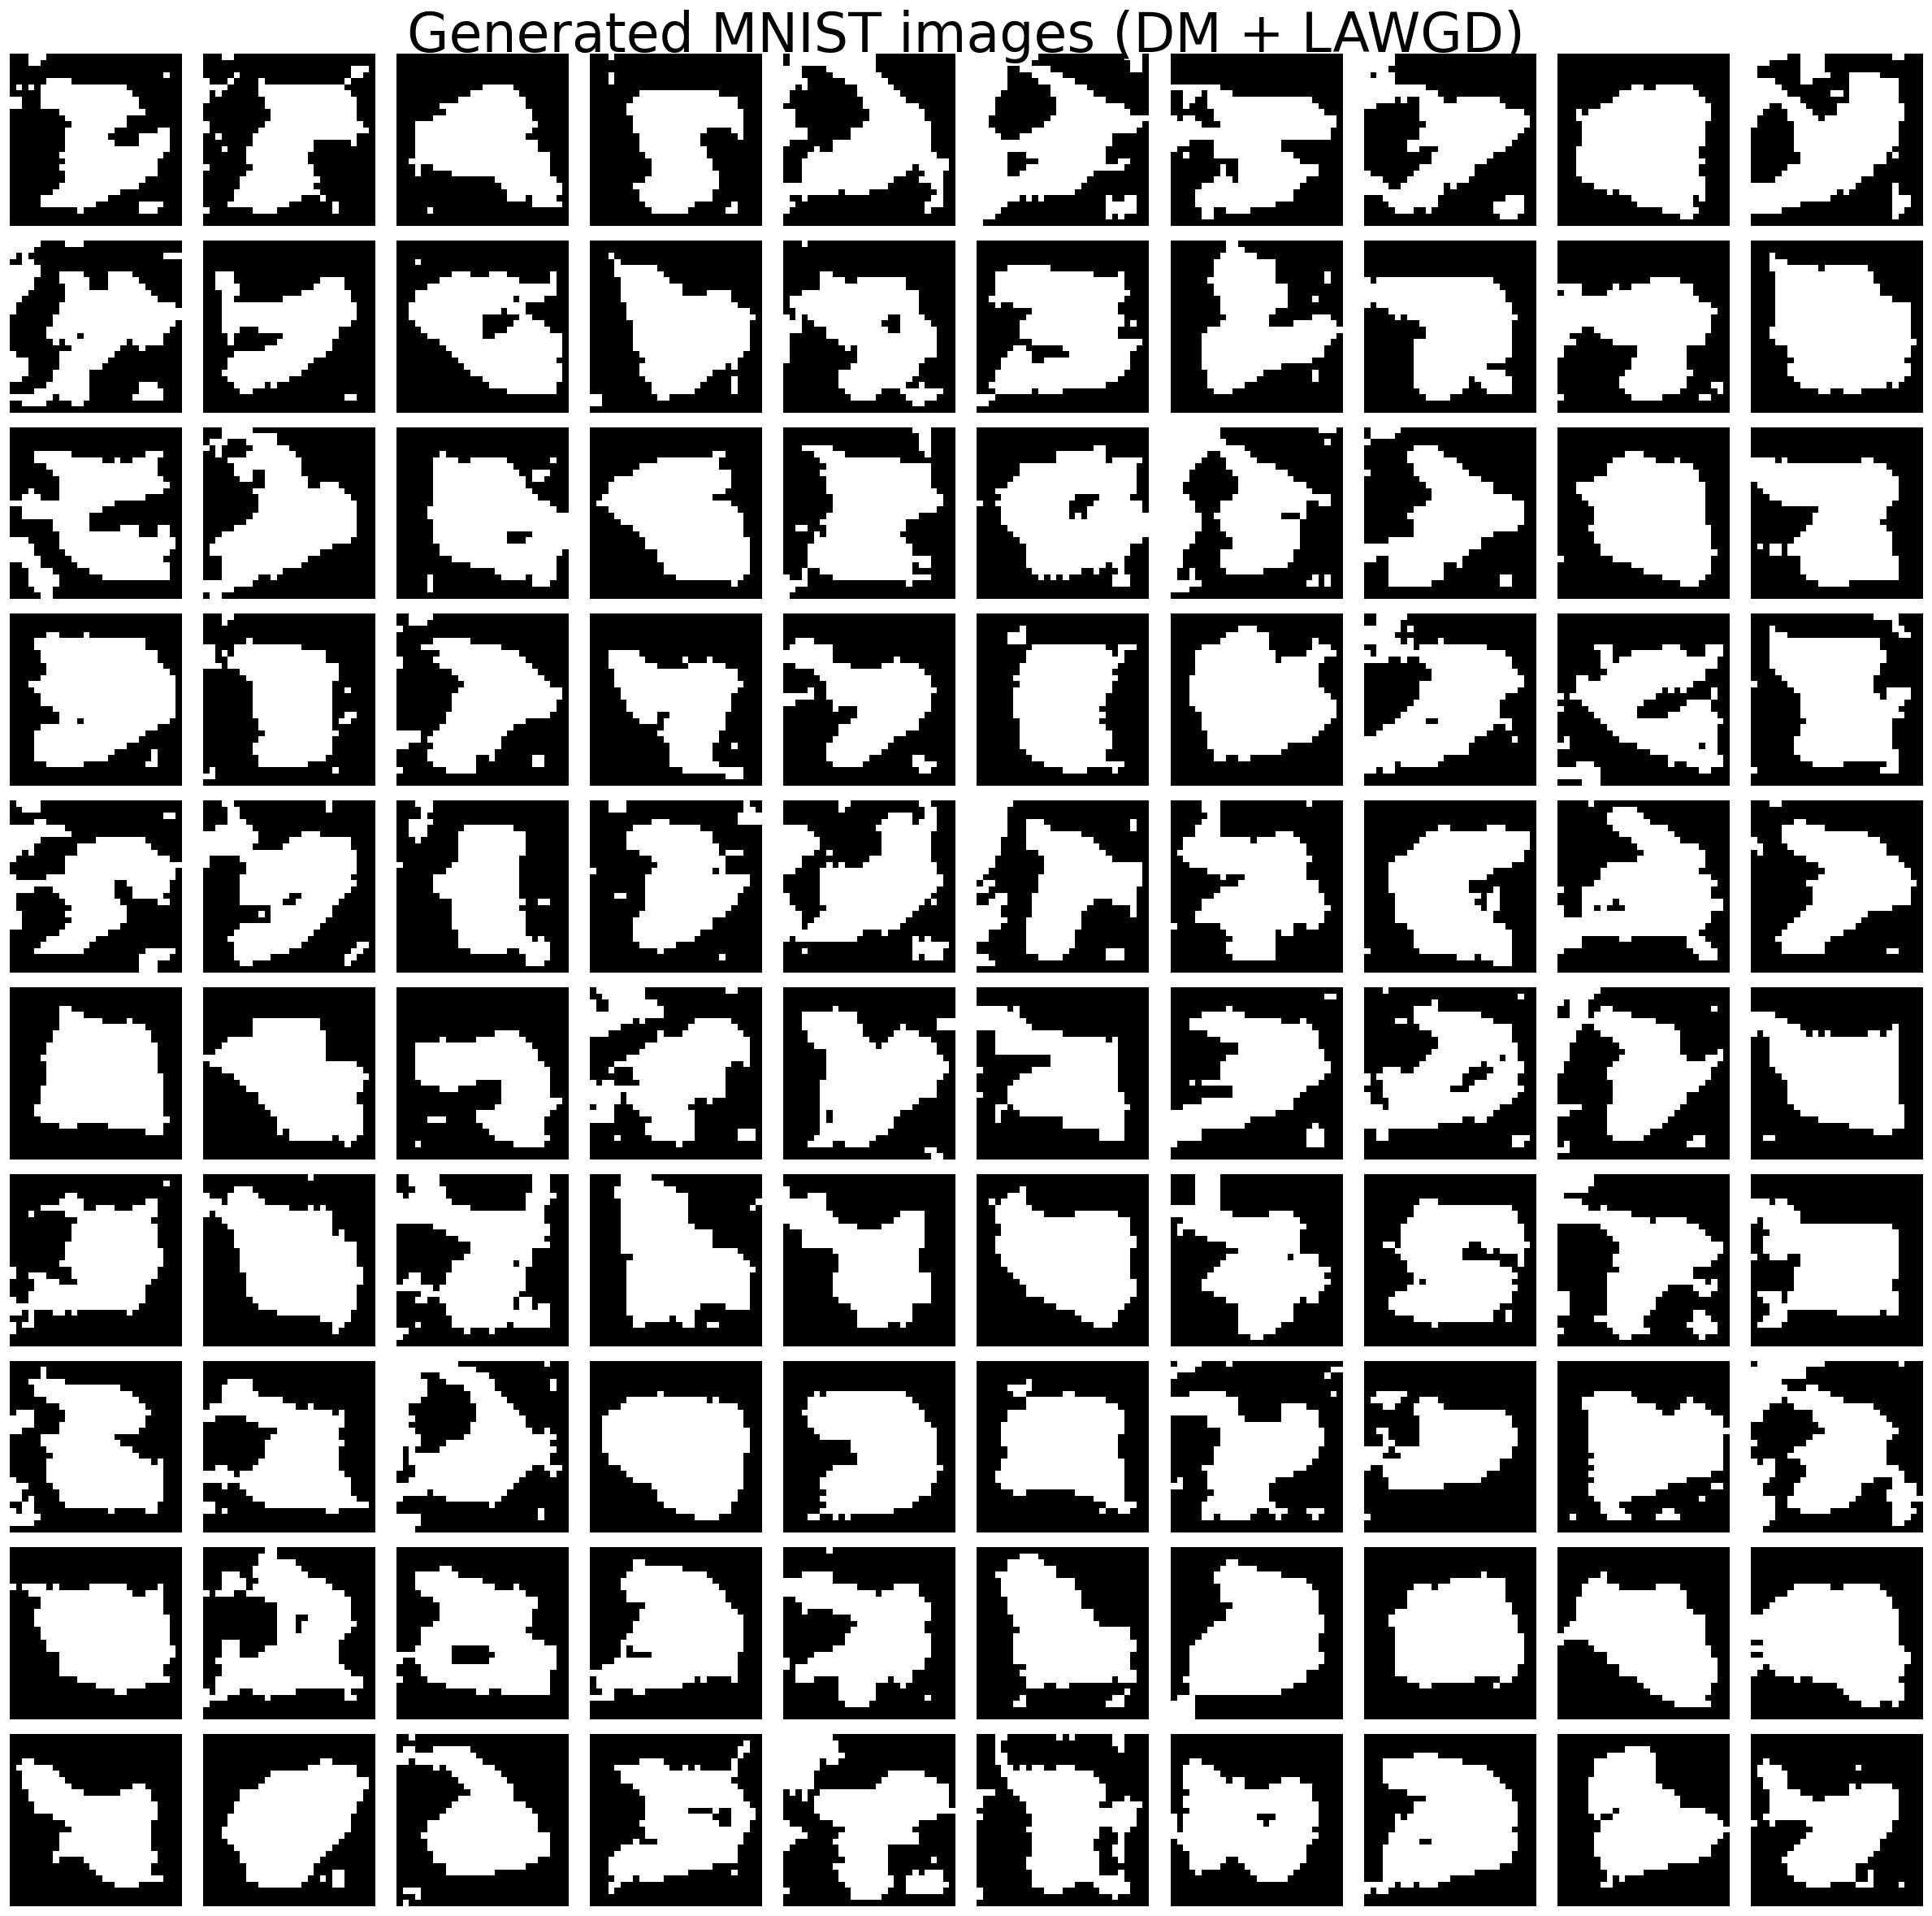

In [84]:
# Visualize digits generated via DM + LAWGD
n_rows_dm = 10
n_cols_dm = 10
n_show_dm = n_rows_dm * n_cols_dm
fig, axes = plt.subplots(n_rows_dm, n_cols_dm, figsize=(2 * n_cols_dm, 2 * n_rows_dm))

for i in range(n_show_dm):
    ax = axes[i // n_cols_dm, i % n_cols_dm]
    ax.imshow(dm_images_cpu[i, 0], cmap="gray")
    ax.axis("off")

plt.suptitle("Generated MNIST images (DM + LAWGD)", fontsize=40)
plt.tight_layout()
plt.show()

In [85]:
# Decode EDMD-LAWGD latent vectors
autoencoder.eval()
Z_new_edmd_tensor = torch.from_numpy(Z_new_lawgd_edmd).float().to(device)

with torch.no_grad():
    edmd_images = autoencoder.decoder(Z_new_edmd_tensor)

edmd_images_cpu = edmd_images.cpu().numpy()
print("EDMD-LAWGD images shape:", edmd_images_cpu.shape)

EDMD-LAWGD images shape: (100, 1, 28, 28)


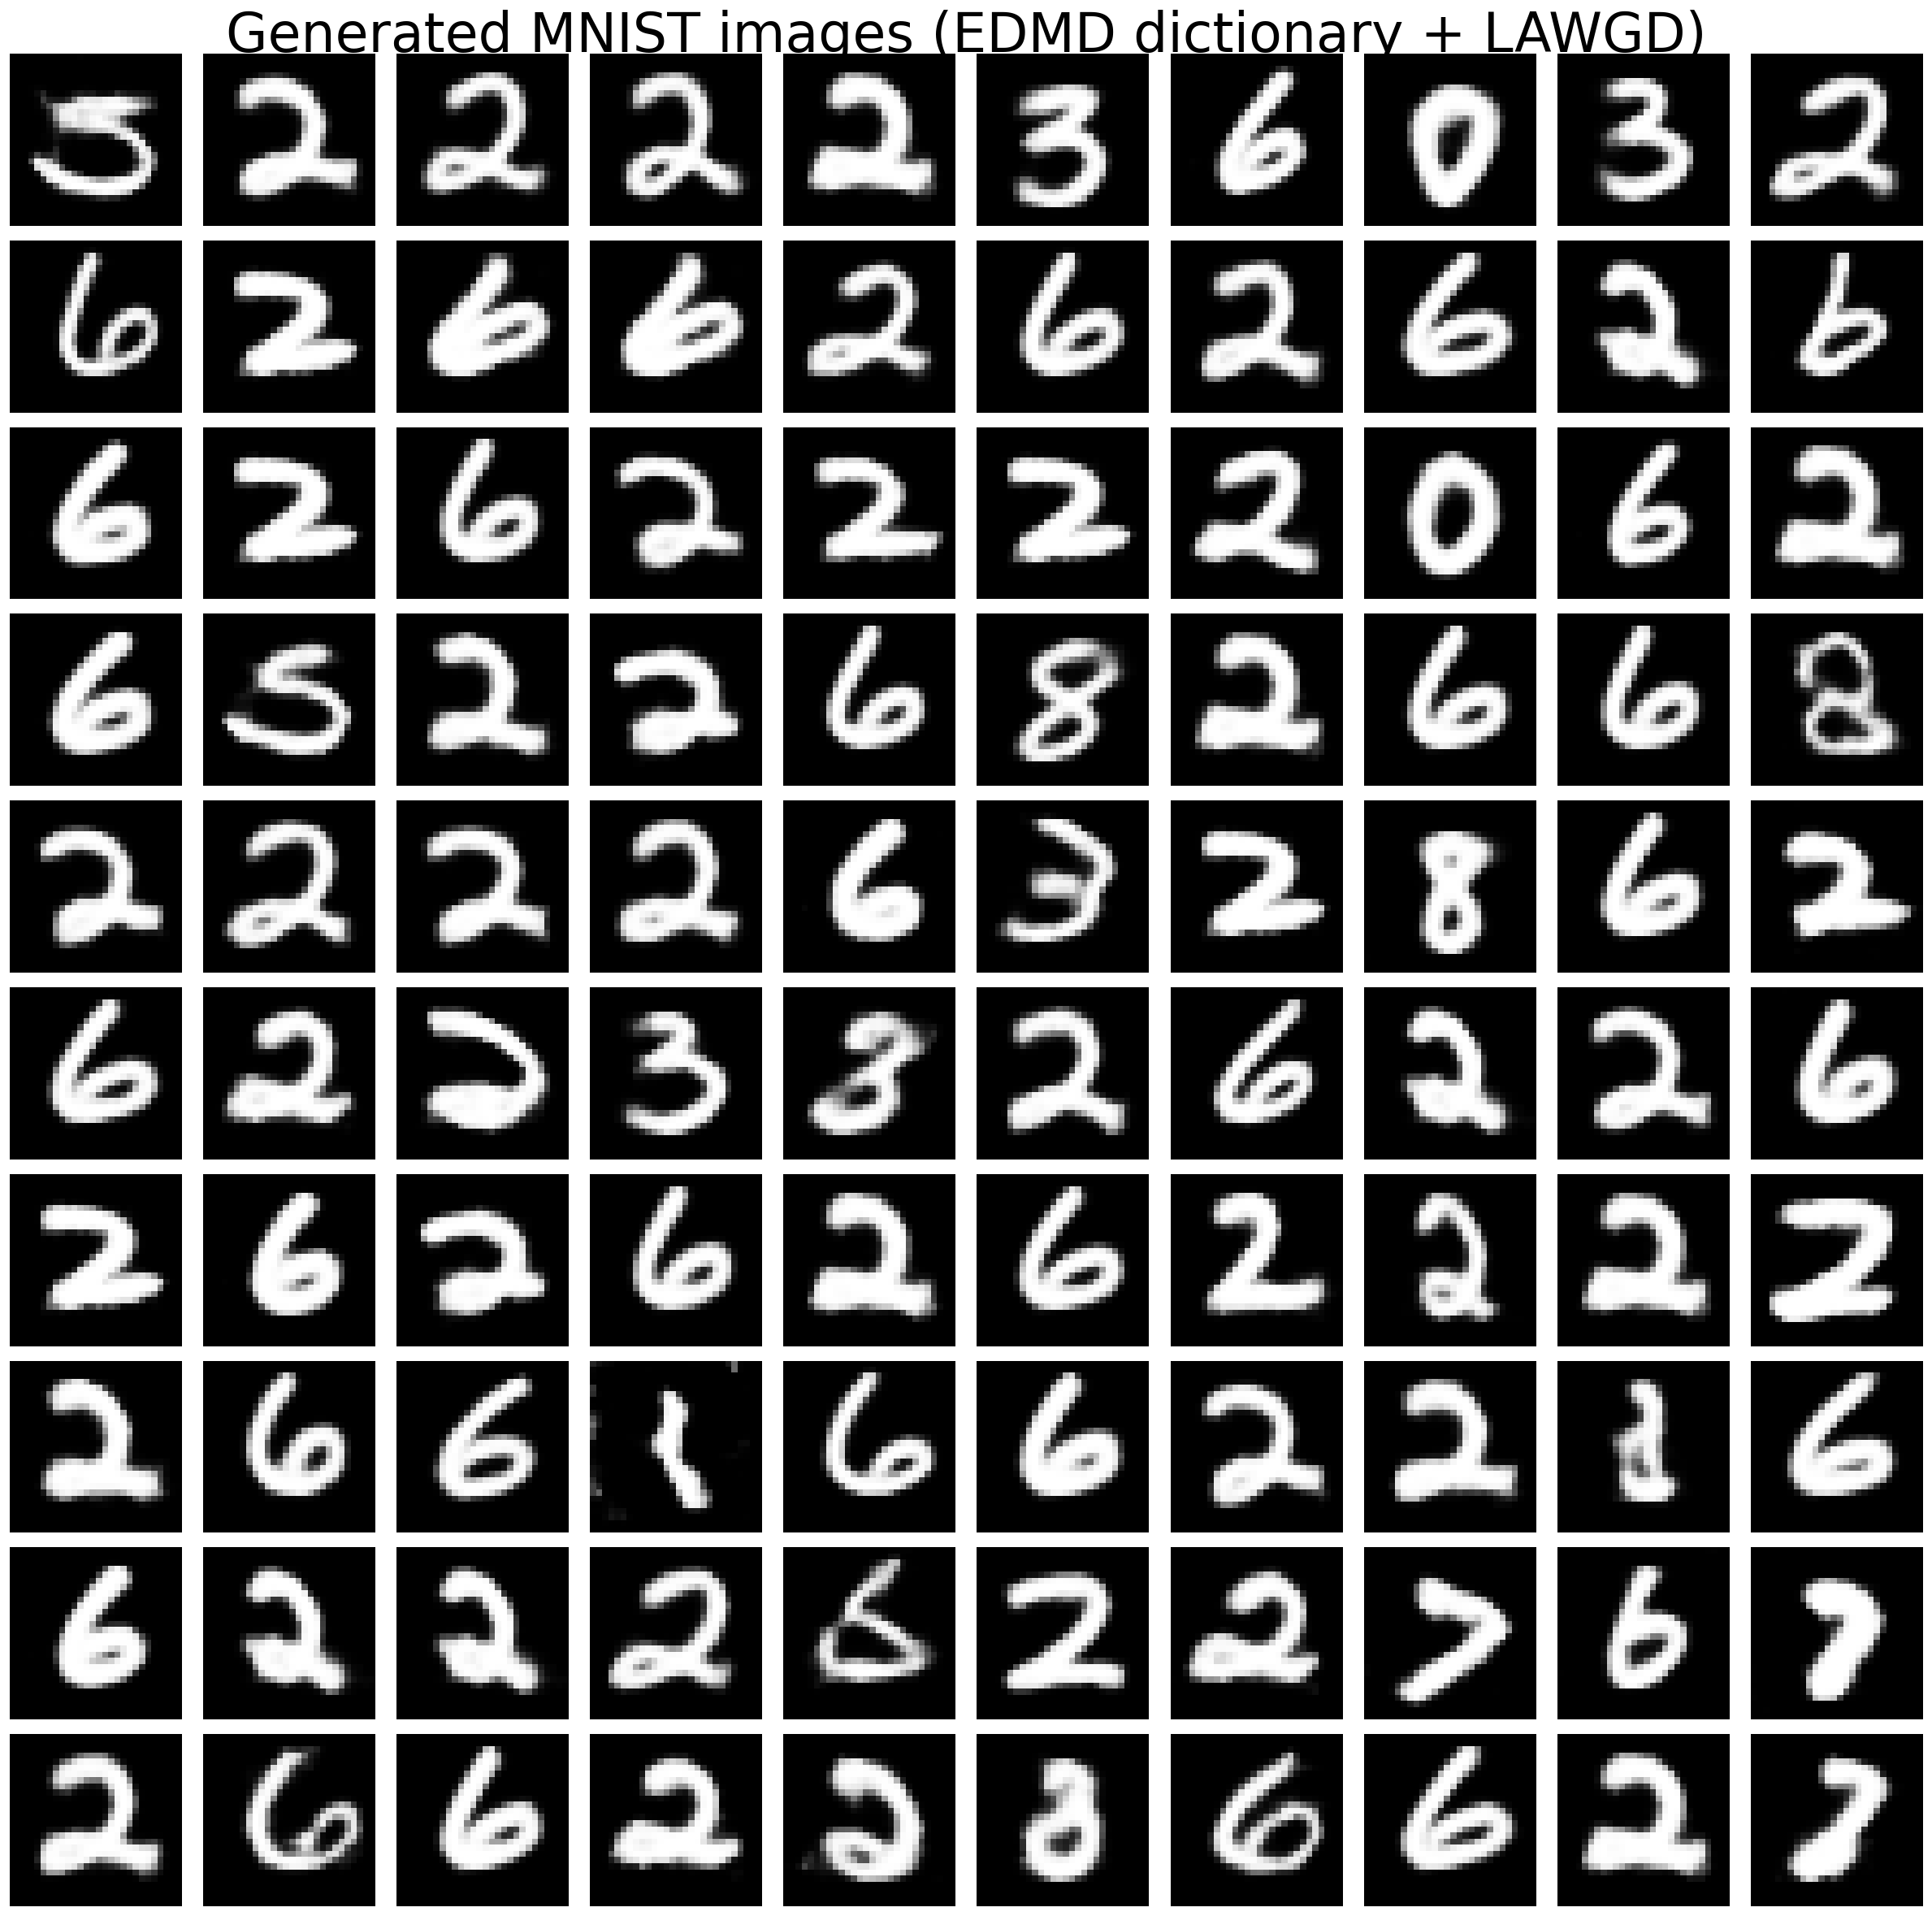

In [86]:
# Visualize digits generated via EDMD + LAWGD
n_rows_edmd = 10
n_cols_edmd = 10
n_show_edmd = n_rows_edmd * n_cols_edmd
fig, axes = plt.subplots(n_rows_edmd, n_cols_edmd, figsize=(2 * n_cols_edmd, 2 * n_rows_edmd))

for i in range(n_show_edmd):
    ax = axes[i // n_cols_edmd, i % n_cols_edmd]
    ax.imshow(edmd_images_cpu[i, 0], cmap="gray")
    ax.axis("off")

plt.suptitle("Generated MNIST images (EDMD dictionary + LAWGD)", fontsize=40)
plt.tight_layout()
plt.show()